In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [176]:
ticker="2603.TW"
data = yf.download(ticker, start='2023-01-01', end='2024-05-20')

[*********************100%%**********************]  1 of 1 completed


In [177]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-03,163.0,164.0,160.0,160.0,87.741936,23603780
2023-01-04,161.0,161.5,156.0,156.0,85.548386,25203463
2023-01-05,158.0,160.5,156.5,156.5,85.822586,20371487
2023-01-06,158.0,159.5,156.0,159.0,87.193550,12082461
2023-01-09,158.0,158.5,154.5,155.0,85.000000,33000304
...,...,...,...,...,...,...
2024-05-13,201.0,210.0,201.0,205.5,205.500000,154541830
2024-05-14,206.0,225.0,204.0,215.0,215.000000,164624198
2024-05-15,206.0,208.0,202.0,203.5,203.500000,81981976


In [178]:
# 计算移动平均线
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_30'] = data['Close'].rolling(window=30).mean()

# 计算KD线
low_14 = data['Low'].rolling(window=14).min()
high_14 = data['High'].rolling(window=14).max()
data['%K'] = (data['Close'] - low_14) * 100 / (high_14 - low_14)
data['%D'] = data['%K'].rolling(window=3).mean()

In [179]:
#交易訊號
data['Signal'] = 0

In [180]:
# 买入条件：10日MA上穿30日MA，且%K低于%D且低于20，且交易量高于20日均线
data.loc[(data['SMA_10'] > data['SMA_30']) & 
         (data['%K'] < data['%D']) & (data['%K'] < 20), 'Signal'] = 1

# 卖出条件：10日MA下穿30日MA，且%K高于%D且高于80，且交易量低于20日均线
data.loc[(data['SMA_10'] < data['SMA_30']) & 
         (data['%K'] > data['%D']) & (data['%K'] > 80), 'Signal'] = -1

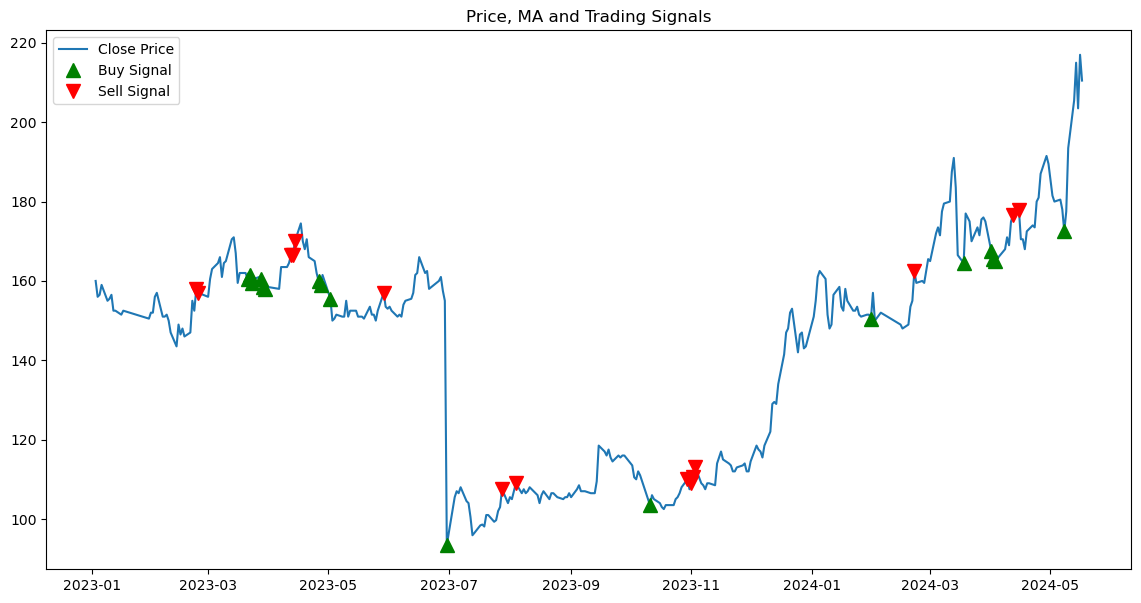

In [181]:
plt.figure(figsize=(14,7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data[data['Signal'] == 1].index, data['Close'][data['Signal'] == 1], '^', markersize=10, color='g', lw=0, label='Buy Signal')
plt.plot(data[data['Signal'] == -1].index, data['Close'][data['Signal'] == -1], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
plt.title('Price, MA and Trading Signals')
plt.legend()
plt.show()

In [182]:
# 計算每日回報
data['Strategy_Return'] = data['Close'].pct_change() * data['Signal'].shift(1)

# 計算策略的累積回報
data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return']).cumprod()

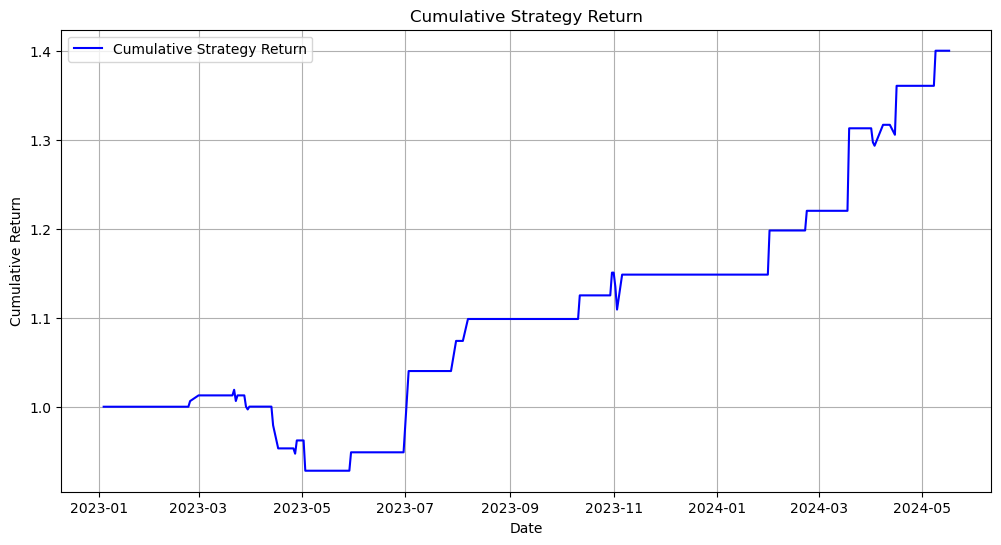

In [183]:
# 创建图表
plt.figure(figsize=(12, 6))

# 绘制策略的累积回报率图表
plt.plot(data['Cumulative_Strategy_Return'], label='Cumulative Strategy Return', color='b')

# 添加标题和标签
plt.title('Cumulative Strategy Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')

# 添加网格线
plt.grid(True)

# 添加图例
plt.legend()

# 显示图表
plt.show()

In [184]:
# 計算最大回撤
data['Peak'] = data['Cumulative_Strategy_Return'].cummax()
data['Drawdown'] = (data['Cumulative_Strategy_Return'] - data['Peak']) / data['Peak']
max_drawdown = data['Drawdown'].min()

print(f"最大回撤率: {max_drawdown:.2%}")

最大回撤率: -8.93%


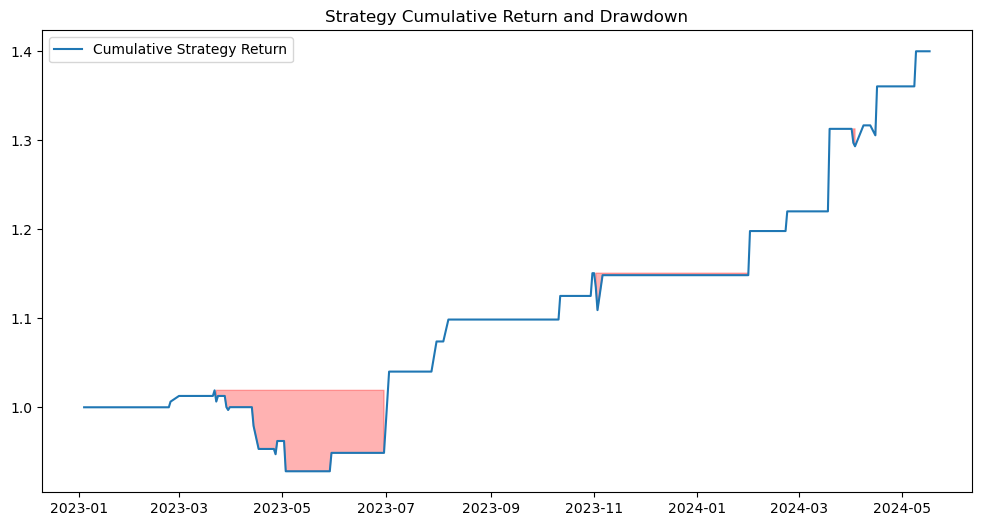

In [185]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Cumulative_Strategy_Return'], label='Cumulative Strategy Return')
# 不再使用 'Cumulative_Benchmark_Return' 列
# plt.plot(data['Cumulative_Benchmark_Return'], label='Cumulative Benchmark Return', linestyle='--')
plt.fill_between(data.index, data['Cumulative_Strategy_Return'], data['Peak'], where=data['Cumulative_Strategy_Return'] < data['Peak'], color='red', alpha=0.3)
plt.title('Strategy Cumulative Return and Drawdown')
plt.legend()
plt.show()